#IS 675 Lab3: Pretrained Networks


In [ ]:
# Import rquired libraries
from torchvision import models
from torchvision import transforms
import torch
import torch.nn as nn
from PIL import Image
from google.colab import drive

In [ ]:
# Mounting Google Drive
drive.mount('/content/drive')

###1. Obtaining a pretrained network for image recognition

The predefined models can be found in torchvision.models

We can take a look at the actual models:
The capitalized names refer to Python classes that implement a number of popular
models. They differ in their architecture—that is, in the arrangement of the operations occurring between the input and the output. The lowercase names are convenience functions that return models instantiated from those classes, sometimes with different parameter sets. For instance, resnet101 returns an instance of ResNet with 101 layers, resnet18 has 18 layers, and so on.

In [ ]:
# List of pretrained models from torchvision
dir(models)

###2. AlextNet
The AlexNet architecture won the 2012 ILSVRC by a large margin, with a top-5 test error rate (that is, the correct label must be in the top 5 predictions) of 15.4%. By comparison, the second-best submission, which wasn’t based on a deep network, trailed at 26.2%. This was a defining moment in the history of computer vision: the moment when the community started to realize the potential of deep learning for vision tasks. That leap was followed by constant improvement, with more modern architectures and training methods getting top-5 error rates as low as 3%.

By today’s standards, AlexNet is a rather small network! See the Alexnet structure below:

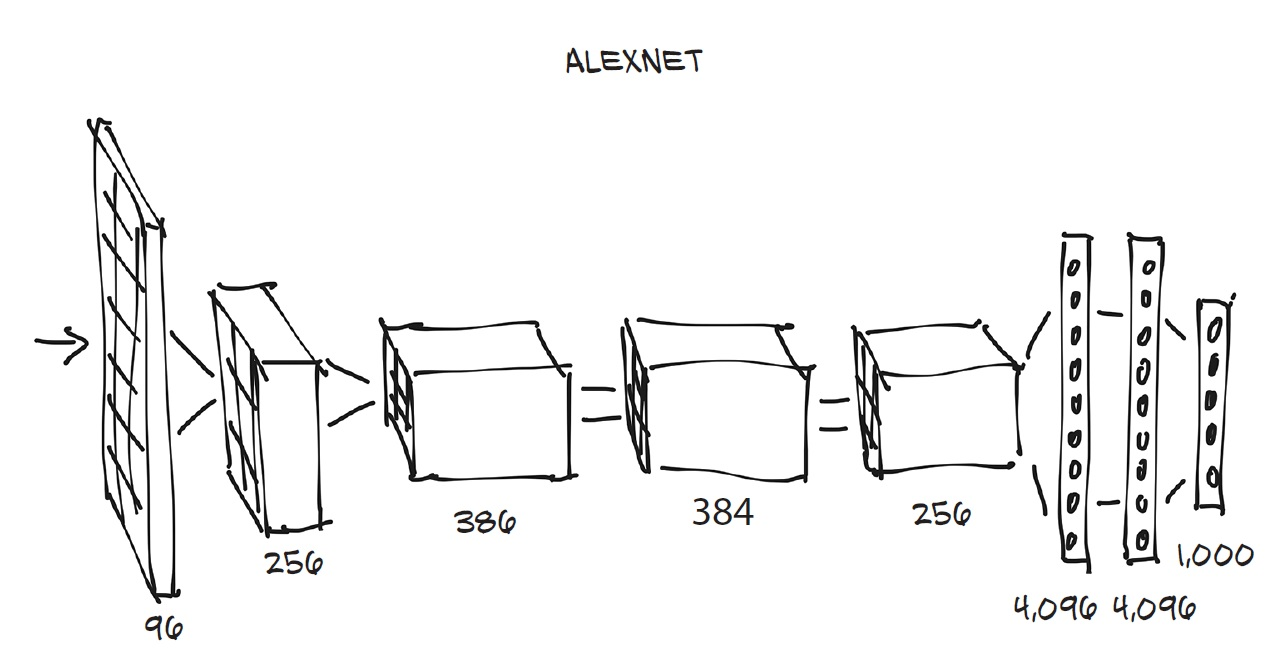

In [ ]:
# The AlexNet architecture
alexnet = models.AlexNet()
#alexnet

At this point, alexnet is an object that can run the AlexNet architecture. It’s not essential for us to understand the details of this architecture for now. For the time being, AlexNet is just an opaque object that can be called like a function. By providing alexnet with some precisely sized input data (we’ll see shortly what this input data should be), we will run a forward pass through the network. That is, the input will run through the first set of neurons, whose outputs will be fed to the next set of neurons, all the way to the final output. Practically speaking, assuming we have an input object of the right type, we can run the forward pass with output = alexnet(input). Should we do that?

###3. ResNet
Let’s create an instance of a network now. We’ll pass an argument that will
instruct the function to download the weights of resnet101 trained on the ImageNet dataset, with 1.2 million images and 1,000 categories.

While we’re staring at the download progress, we can take a minute to appreciate that resnet101 sports 44.5 million parameters—that’s a lot of parameters to optimize automatically!

In [ ]:
# Instantiate a 101-layer convolutional neural network
resnet = models.resnet101(pretrained=True)

In [ ]:
# The resnet101 architecture
resnet

###4. Ready, set, almost run
The resnet variable can be called like a function, taking as input one or more
images and producing an equal number of scores for each of the 1,000 ImageNet
classes. Before we can do that, however, we have to preprocess the input images so they are the right size and so that their values (colors) sit roughly in the same numerical range. In order to do that, the torchvision module provides transforms, which allow us to quickly define pipelines of basic preprocessing functions:

In [ ]:
# Preprocess the image
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )])

The preprocess function will scale the input image to 256 × 256, crop the image to 224 × 224 around the center, transform it to a tensor (a PyTorch multidimensional array: in this case, a 3D array with color, height, and width), and normalize its RGB (red, green, blue) components so that they have
defined means and standard deviations. These need to match what was presented to
the network during training.

Now let's grab a picture, preprocess it, and then see what ResNet thinks of it.

In [ ]:
# Import an image
img = Image.open("/content/drive/MyDrive/IS675_data/bobby.jpg")

In [ ]:
img

In [ ]:
# Preprocess the image
img_t = preprocess(img)
#img_t

Then we can reshape, crop, and normalize the input tensor in a way that the network expects. We’ll understand more of this in the next chapters; hold tight for now:

In [ ]:
# Adding a dimension to our image to make it a batch of one image!
batch_t = torch.unsqueeze(img_t, 0)
#batch_t

We’re now ready to run our model.
###5. Run

The process of running a trained model on new data is called ***inference*** in deep learning circles. In order to do inference, we need to put the network in ***eval*** mode:
(If we forget to do that, some pretrained models, like batch normalization and dropout, will not produce meaningful answers, just because of the way they work internally.)

In [ ]:
# Put the model in eval mode
resnet.eval()

In [ ]:
# Inference
out = resnet(batch_t)
#out

A staggering set of operations involving **44.5 million parameters** has just happened, producing a vector of 1,000 scores, one per ImageNet class. That didn’t take long, did it?

We now need to find out the label of the class that received the highest score.

In [ ]:
# The list of predicted labels
with open('/content/drive/MyDrive/IS675_data/imagenet_classes.txt') as f:
    labels = [line.strip() for line in f.readlines()]
#labels

In [ ]:
# Determine the index corresponding to the maximum score in the out tensor
_, index = torch.max(out, 1)
index

In [ ]:
# Normalize our outputs to the range [0, 1]
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
labels[index[0]], percentage[index[0]].item()

In [ ]:
# Determine the top five indices corresponding to the top best scores in the out tensor
_, indices = torch.sort(out, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

###6. CycleGAN
A CycleGAN can turn images of one domain into images of another domain (and back), without the need for us to explicitly provide matching pairs in the training set. The CycleGAN network has been trained on a dataset of (unrelated) horse images and zebra images extracted from the ImageNet
dataset.

In [ ]:
class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3>

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

In [ ]:
# Define a ResNetGenerator class
netG = ResNetGenerator()

We mentioned earlier that we would run a generator model that had been pretrained on the horse2zebra dataset, whose training set contains two sets of 1068 and 1335 images of horses and zebras, respectively. The dataset be found at http://mng.bz/8pKP. The weights of the model have been saved in a .pth file, which is nothing but a pickle file of the model’s tensor parameters. We can load those into ResNetGenerator using the model’s load
_state_dict method:

In [ ]:
# Load the weights
model_path = '/content/drive/MyDrive/IS675_data/horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

This is fully equivalent to what happened when we loaded resnet101 from torchvision.

In [ ]:
# Put the model in eval mode
netG.eval()

It takes an image, recognizes one or more horses in it by looking at pixels, and individually modifies the values of those pixels so that what comes out looks like a credible zebra. We won’t recognize anything zebra-like in the
printout (or in the source code, for that matter): that’s because there’s nothing zebralike in there. The network is a scaffold—the juice is in the weights.

In [ ]:
# Load a random image of a horse
img = Image.open("/content/drive/MyDrive/IS675_data/horse.jpg")
img

In [ ]:
#preprocess = transforms.Compose([transforms.Resize(256),
                               # transforms.ToTensor()])

In [ ]:
# Preprocess the image
img_t = preprocess(img)

In [ ]:
# Adding a dimension to our image to make it a batch of one image!
batch_t = torch.unsqueeze(img_t, 0)
#batch_t

In [ ]:
# Inference
batch_out = netG(batch_t)

In [ ]:
# convert batch_out back to an image
out_t = (batch_out.data.squeeze() + 1.0) / 2.0
out_img = transforms.ToPILImage()(out_t)
#out_img.save('/content/drive/MyDrive/IS675_data/zebra.jpg')
out_img

Q1- Turn bobby into a zebra!

Q2- Classify the horse image.

Q3- Turn a random group of horses into zebras.

Q4- Classify a random picture and try to fool the model (I am looking for misclassification instances where the model is totally off in its prediction wrt top five choices)